Installing the required libraries
Imported the required libraries, I first used the keras library till last but for larger epochs it was taking a lot of time, so on the last day I switched to pytorch as I had even used Pytorch before in my earlier project but since most of the resources provided were in Keras, I used the keras first.

In [4]:
import gym
import numpy as np
import random
from collections import deque
import os
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

In [5]:
# Create directories to save model output
output_dir = 'model_output/cartpole1/'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
with open(output_dir+"scores.txt", "w") as f:
    f.write("")

At first, I tried the game breakdown - v4 but that didn't worked out. It gave me tough times in installation and debugging because the atari version of gym don't work with pythons >= 3.10. So, I tried to create conda environment and the different installations all messed up as google colab didn't worked with gym atari and doesn't support environment as usual so I switched back to the Cartpole - v1 game

In [6]:
env = gym.make('CartPole-v1',render_mode="rgb_array") # Create the environment for the cartpole

In [7]:
# Hyperparameters
learning_rate = 0.0005
batch_size = 32
n_episodes = 200
deque_memory_size = 5000
output_dir = 'model_output/cartpole1/'

epsilon = 1.0
epsilon_decay = 0.99
epsilon_min = 0.01
gamma = 0.999  # discount factor

# Environment variables
# 4 = cart position, cart velocity, pole angle, pole velocity at the tip
state_size = env.observation_space.shape[0]
action_size = env.action_space.n  # two actions: left and right

4-layer architecture:
Input layer  = 4 neurons (State-Size)
Hidden Layer 1 = 32 neurons
Hidden Layer 2 = 32 neurons
Actions = 2 neurons (2-actions : 0 and 1)

In [8]:
# Define the DQN model
class DQN(nn.Module):
    def __init__(self):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(state_size, 32)
        self.fc2 = nn.Linear(32, 32)
        self.fc3 = nn.Linear(32, action_size)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [9]:
class DQNAgent:
    def __init__(self):
        self.model = DQN()
        self.target_model = DQN()
        self.optimizer = optim.Adam(self.model.parameters(), lr=learning_rate)
        self.loss_fn = nn.MSELoss()
        self.memory = deque(maxlen=deque_memory_size)
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min
        self.gamma = gamma

    def act(self, state, explore=True):
        if explore and np.random.rand() <= self.epsilon: #if explore is true, and random value less than epsilon, return random action
            return random.randrange(action_size)
        state = torch.FloatTensor(state) 
        with torch.no_grad():
            q_values = self.model(state)
        return np.argmax(q_values.numpy())

    def remember(self, state, action, reward, next_state, done): #remember the state, action, reward, next state, and done
        self.memory.append((state, action, reward, next_state, done))

    def replay(self, batch_size): #replay the memory
        if len(self.memory) < batch_size: #if memory is less than batch size,
            return
        minibatch = random.sample(self.memory, batch_size) #randomly sample the memory
        for state, action, reward, next_state, done in minibatch:
            state = torch.FloatTensor(state)
            next_state = torch.FloatTensor(next_state)
            
            # Update the Q-value
            target = reward
            
            # If the episode is not done, update the target value using Bellman equation
            if not done:
                target = (reward + self.gamma * torch.max(self.target_model(next_state)).item())

            target_f = self.model(state)
            target_f = target_f.clone()
            target_f[0][action] = target
            
            self.optimizer.zero_grad()
            output = self.model(state)
            loss = self.loss_fn(output, target_f)
            loss.backward()
            self.optimizer.step()

    def update_target_model(self): #update the target model
        self.target_model.load_state_dict(self.model.state_dict())

    def save(self, name): #save the model
        torch.save(self.model.state_dict(), name)
        
    def load(self, name): #load the model - trained weights
        self.model.load_state_dict(torch.load(name))
        self.target_model.load_state_dict(torch.load(name))

In [7]:
# Train the agent
agent = DQNAgent()
done = False
scores = []  # store the scores

for e in range(n_episodes):
    state = env.reset()
    if isinstance(state, tuple):
        state = np.array(state[0]).reshape([1, state_size])
        # print(state)
    done = False
    tReward = 0
    while not done:
        # env.render()
        action = agent.act(state)
        step_action = env.step(action)

        next_state = np.array(step_action[0]).reshape([1, state_size])
        reward = step_action[1]
        done = step_action[2]

        agent.remember(state, action, reward, next_state, done)
        state = next_state

        tReward += reward
        agent.replay(batch_size)
        
        if tReward >= 700: #if the reward is greater than 700, break the loop
            done = True

    agent.update_target_model()
    scores.append(tReward)
    print(f"Episode: {e}/{n_episodes}, Score: {tReward}, Epsilon: {agent.epsilon:.2}")
    # appending the score in a file
    with open(output_dir+'scores.txt', 'a') as file:
        file.write(
            f"Episode: {e}/{n_episodes}, Score: {tReward}, Epsilon: {agent.epsilon:.2}\n")
    if agent.epsilon > agent.epsilon_min:
        agent.epsilon *= agent.epsilon_decay
    if (e+1) % 50 == 0:
        agent.save(output_dir + f'model-{e+1}.weights.pth')

c:\Users\abhij\AppData\Local\Programs\Python\Python312\Lib\site-packages\gym\utils\passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Episode: 0/200, Score: 9.0, Epsilon: 1.0
Episode: 1/200, Score: 13.0, Epsilon: 0.99
Episode: 2/200, Score: 39.0, Epsilon: 0.98
Episode: 3/200, Score: 30.0, Epsilon: 0.97
Episode: 4/200, Score: 35.0, Epsilon: 0.96
Episode: 5/200, Score: 59.0, Epsilon: 0.95
Episode: 6/200, Score: 26.0, Epsilon: 0.94
Episode: 7/200, Score: 35.0, Epsilon: 0.93
Episode: 8/200, Score: 24.0, Epsilon: 0.92
Episode: 9/200, Score: 31.0, Epsilon: 0.91
Episode: 10/200, Score: 15.0, Epsilon: 0.9
Episode: 11/200, Score: 14.0, Epsilon: 0.9
Episode: 12/200, Score: 39.0, Epsilon: 0.89
Episode: 13/200, Score: 29.0, Epsilon: 0.88
Episode: 14/200, Score: 23.0, Epsilon: 0.87
Episode: 15/200, Score: 16.0, Epsilon: 0.86
Episode: 16/200, Score: 21.0, Epsilon: 0.85
Episode: 17/200, Score: 32.0, Epsilon: 0.84
Episode: 18/200, Score: 16.0, Epsilon: 0.83
Episode: 19/200, Score: 18.0, Epsilon: 0.83
Episode: 20/200, Score: 27.0, Epsilon: 0.82
Episode: 21/200, Score: 11.0, Epsilon: 0.81
Episode: 22/200, Score: 16.0, Epsilon: 0.8
Epi

[9.0, 13.0, 39.0, 30.0, 35.0, 59.0, 26.0, 35.0, 24.0, 31.0, 15.0, 14.0, 39.0, 29.0, 23.0, 16.0, 21.0, 32.0, 16.0, 18.0, 27.0, 11.0, 16.0, 35.0, 13.0, 32.0, 24.0, 51.0, 17.0, 27.0, 45.0, 22.0, 34.0, 22.0, 18.0, 100.0, 18.0, 64.0, 37.0, 54.0, 30.0, 12.0, 67.0, 106.0, 29.0, 48.0, 30.0, 67.0, 97.0, 73.0, 47.0, 146.0, 71.0, 22.0, 166.0, 20.0, 108.0, 150.0, 58.0, 175.0, 33.0, 219.0, 156.0, 64.0, 63.0, 88.0, 262.0, 89.0, 62.0, 134.0, 137.0, 31.0, 155.0, 33.0, 78.0, 165.0, 142.0, 14.0, 97.0, 127.0, 25.0, 11.0, 190.0, 11.0, 163.0, 130.0, 63.0, 109.0, 213.0, 155.0, 141.0, 155.0, 212.0, 178.0, 26.0, 196.0, 145.0, 141.0, 78.0, 160.0, 136.0, 168.0, 110.0, 199.0, 478.0, 251.0, 203.0, 162.0, 158.0, 130.0, 154.0, 84.0, 92.0, 117.0, 13.0, 14.0, 22.0, 125.0, 116.0, 121.0, 14.0, 160.0, 115.0, 140.0, 25.0, 131.0, 130.0, 118.0, 118.0, 125.0, 135.0, 95.0, 131.0, 17.0, 140.0, 156.0, 12.0, 168.0, 162.0, 159.0, 165.0, 217.0, 208.0, 700.0, 700.0, 700.0, 700.0, 700.0, 700.0, 700.0, 538.0, 529.0, 17.0, 700.0, 700

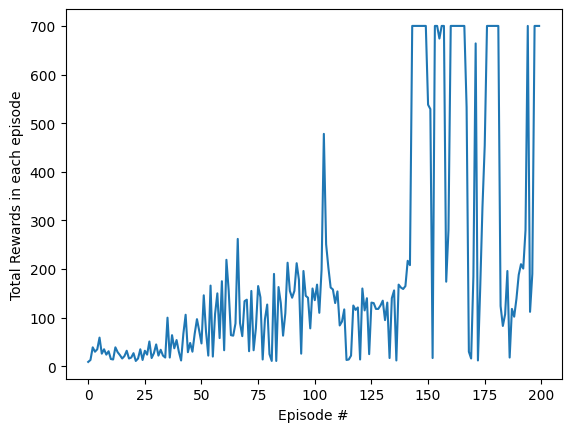

<Figure size 640x480 with 0 Axes>

In [8]:
# Print scores
print(scores)
# Plotting the total rewards
plt.plot(scores)
plt.ylabel('Total Rewards in each episode')
plt.xlabel('Episode #')
plt.show()
plt.savefig('cartpole_rewards.png')

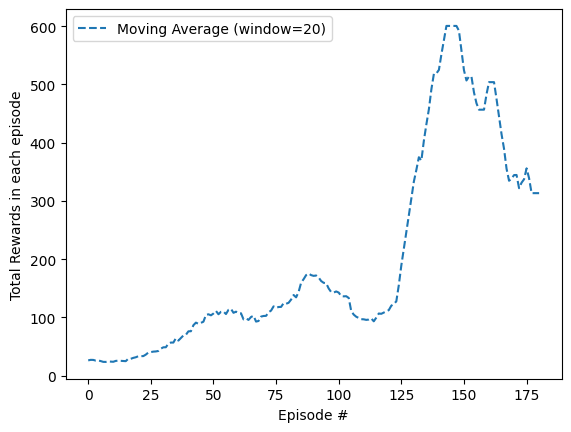

In [16]:
# Calculate moving average for the best-fit line
def moving_average(data, window_size):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')


# Plotting the total rewards
plt.plot(moving_average(scores, 20), label='Moving Average (window=20)', linestyle='--')
plt.ylabel('Total Rewards in each episode')
plt.xlabel('Episode #')
plt.legend()
plt.show()

In [10]:
training_epsilon = 0

def evaluate_agent(agent, env, n_episodes=10):
    agent.epsilon = training_epsilon
    total_rewards = []
    for e in range(n_episodes):
        state = env.reset()
        if isinstance(state, tuple):
            state = np.array(state[0]).reshape([1, state_size])
        done = False
        tReward = 0
        while not done:
            action = agent.act(state)
            step_action = env.step(action)

            next_state = np.array(step_action[0]).reshape([1, state_size])
            reward = step_action[1]
            done = step_action[2]

            state = next_state
            tReward += reward
            if(tReward >= 700):
                done = True
        
        total_rewards.append(tReward)
        print(f"Episode: {e+1}/{n_episodes}, Score: {tReward}")

    avg_reward = np.mean(total_rewards)
    print(f"Average Reward over {n_episodes} episodes: {avg_reward}")
    return total_rewards, avg_reward

agent = DQNAgent()

In [11]:
# Load and evaluate the model
agent.load(output_dir + 'model-50.weights.pth')

# Evaluate the agent
evaluate_agent(agent, env)

c:\Users\abhij\AppData\Local\Programs\Python\Python312\Lib\site-packages\gym\utils\passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Episode: 1/10, Score: 170.0
Episode: 2/10, Score: 202.0
Episode: 3/10, Score: 385.0
Episode: 4/10, Score: 493.0
Episode: 5/10, Score: 251.0
Episode: 6/10, Score: 288.0
Episode: 7/10, Score: 139.0
Episode: 8/10, Score: 144.0
Episode: 9/10, Score: 306.0
Episode: 10/10, Score: 144.0
Average Reward over 10 episodes: 252.2


([170.0, 202.0, 385.0, 493.0, 251.0, 288.0, 139.0, 144.0, 306.0, 144.0], 252.2)

In [12]:
# Load and evaluate the model
agent.load(output_dir + 'model-100.weights.pth')

# Evaluate the agent
evaluate_agent(agent, env)

Episode: 1/10, Score: 123.0
Episode: 2/10, Score: 122.0
Episode: 3/10, Score: 130.0
Episode: 4/10, Score: 118.0
Episode: 5/10, Score: 121.0
Episode: 6/10, Score: 119.0
Episode: 7/10, Score: 132.0
Episode: 8/10, Score: 126.0
Episode: 9/10, Score: 119.0
Episode: 10/10, Score: 120.0
Average Reward over 10 episodes: 123.0


([123.0, 122.0, 130.0, 118.0, 121.0, 119.0, 132.0, 126.0, 119.0, 120.0], 123.0)

In [13]:
# Load and evaluate the model
agent.load(output_dir + 'model-150.weights.pth')

# Evaluate the agent
evaluate_agent(agent, env)

Episode: 1/10, Score: 700.0
Episode: 2/10, Score: 700.0
Episode: 3/10, Score: 700.0
Episode: 4/10, Score: 700.0
Episode: 5/10, Score: 700.0
Episode: 6/10, Score: 700.0
Episode: 7/10, Score: 700.0
Episode: 8/10, Score: 700.0
Episode: 9/10, Score: 700.0
Episode: 10/10, Score: 700.0
Average Reward over 10 episodes: 700.0


([700.0, 700.0, 700.0, 700.0, 700.0, 700.0, 700.0, 700.0, 700.0, 700.0], 700.0)

In [14]:
# Load and evaluate the model
agent = DQNAgent()
agent.load(output_dir + 'model-200.weights.pth')

# Evaluate the agent
evaluate_agent(agent, env)

Episode: 1/10, Score: 700.0
Episode: 2/10, Score: 700.0
Episode: 3/10, Score: 700.0
Episode: 4/10, Score: 700.0
Episode: 5/10, Score: 700.0
Episode: 6/10, Score: 700.0
Episode: 7/10, Score: 700.0
Episode: 8/10, Score: 700.0
Episode: 9/10, Score: 700.0
Episode: 10/10, Score: 700.0
Average Reward over 10 episodes: 700.0


([700.0, 700.0, 700.0, 700.0, 700.0, 700.0, 700.0, 700.0, 700.0, 700.0], 700.0)

There is consistent high output because we have turned exploration off and exploited the values.